In [1]:
%load_ext autoreload
%autoreload 1
%aimport ecg_get_data
%aimport Models
%aimport train_test_validat
%aimport self_attention
%aimport ECGplot
%aimport cam
%aimport Net
%aimport select_dataset
import select_dataset
import Net
import random
import Models 
from train_test_validat import *
import  ecg_get_data 
import ECGplot
import cam 

import torch
import torch.utils.data as Data
import matplotlib.pyplot as plt

random_seed = 2
torch.manual_seed(random_seed)    # reproducible
torch.cuda.manual_seed_all(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

test_npy_path =  './data/test/' #路径
xml_path = './xml/xml/'
lead_index = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
EcgChannles_num = 12
EcgLength_num = 5000
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [37]:
DEVICE = 'cpu'

In [2]:
data = select_dataset.splite_dataset('/workspace/data/Preprocess_HTN/data/',True)
test_list = data.__get_test_file_list__(True,'外科')
valid_list,train_list,addition_train_list = data.__get_VT_file_list__(0.3,True,'外科') # type: ignore

	
 orginal   fliter department&age
  33342       8479   
	
 orginal   fliter duplicated
   509        423    
	
 orginal   fliter duplicated
   8479       7043   
	
       HTN  NHTN 
test   423   423 
	
 orginal   fliter department&age
  65933      11329   
	
 orginal   fliter duplicated
   1354       1111   
	
 orginal   fliter duplicated
  11329       9216   
	
       HTN  NHTN 
train  333   333 
valid  778   778 
 add    0   8105 


In [3]:
test_Dataset = ecg_get_data.ECG_Dataset('/workspace/data/Preprocess_HTN/data/ECG',test_list,EcgChannles_num,EcgLength_num)

npys:{%d} 846


In [4]:
testmodel = (Net.MLBFNet(True,res = True,se = True,Dropout_rate = 0.3)).to(DEVICE)  # type: ignore
# testmodel = (Models.resnet18(12,64,2)).to(DEVICE)
testmodel.load_state_dict(torch.load("./model/20221104_010310/parameter_best_test_0.pt"))

<All keys matched successfully>

In [5]:
# TEST_BATCH_SIZE = test_Dataset.npys.__len__()
test_dataloader = Data.DataLoader(dataset=test_Dataset, batch_size=170)
test_acc = []   
criterion = torch.nn.CrossEntropyLoss() 
y_true,y_pred,test_loss,test_acc = eval_model(test_dataloader,criterion,testmodel,DEVICE) # 测试模型
print('loss =',test_loss,'acc =',test_acc)
print('f1_macro =',f1_score(y_true, y_pred, average='macro')) 

loss = 0.5343198513650961 acc = 0.7742452161587526
f1_macro = 0.7735910919431519


In [6]:
print('f1_micro =',f1_score(y_true, y_pred, average='micro')) 

f1_micro = 0.7742316784869976


In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
print("Confusion Matrix: ")
print(cm)

Confusion Matrix: 
[[350  73]
 [118 305]]


In [8]:
testmodel.eval()
# 定义获取梯度的函数
fmap_block = list()
grad_block = list()

def backward_hook(module, grad_in, grad_out):
    grad_block.append(grad_out[0].detach())

# 定义获取特征图的函数
def farward_hook(module, input, output):
    fmap_block.append(output)

In [9]:
testmodel.layers0.register_forward_hook(farward_hook)	#正向传播
testmodel.layers1.register_forward_hook(farward_hook) 
testmodel.layers2.register_forward_hook(farward_hook)	#正向传播
testmodel.layers3.register_forward_hook(farward_hook) 
testmodel.layers4.register_forward_hook(farward_hook)	#正向传播
testmodel.layers5.register_forward_hook(farward_hook) 
testmodel.layers6.register_forward_hook(farward_hook)	#正向传播
testmodel.layers7.register_forward_hook(farward_hook) 
testmodel.layers8.register_forward_hook(farward_hook)	#正向传播
testmodel.layers9.register_forward_hook(farward_hook) 
testmodel.layers10.register_forward_hook(farward_hook)	#正向传播
testmodel.layers11.register_forward_hook(farward_hook) 
testmodel.conv3.register_forward_hook(farward_hook) 
testmodel.layers_list_2d[0].register_forward_hook(farward_hook) 
testmodel.layers_list_2d[1].register_forward_hook(farward_hook) 
testmodel.layers_list_2d[2].register_forward_hook(farward_hook) 

In [10]:
fmap_block.__len__()

0

In [11]:
branch_fmap_sum_HTN = np.zeros(27)
branch_fmap_sum_NHTN = np.zeros(27)
for itme in (range(845)):
    # testmodel.layer4.register_forward_hook(farward_hook)	#正向传播
    # testmodel.layer4.register_full_backward_hook(backward_hook)#反向传播
    fmap_block = list()
    grad_block = list()
    inputs,labels = test_Dataset.__getitem__(itme)
    labels = torch.tensor(labels)
    labels = labels.unsqueeze(0) # 在首位添加1维作为batchsize
    inputs = inputs.unsqueeze(0) # 在首位添加1维作为batchsize

    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)  
    testmodel.eval()
    outputs = testmodel(inputs)
    _,pred = outputs.max(1)     # 求概率最大值对应的标签
    # print("labels: {}".format(labels))
    # print("predict: {}".format(pred))
    # loss = outputs[0,pred]      # 网络对应于pred的类别的输出即为loss
    # # loss = (testmodel.last_out)[0,pred]
    # loss.backward(retain_graph=True)  #retain_graph=True，目的为是为保留该过程中计算的梯度，后续G网络更新时使用
    if(((labels.tolist())[0]) == [0,1]):
        for i in range(12):
            branch_fmap_sum_HTN[i]= branch_fmap_sum_HTN[i] + fmap_block[i].to('cpu').sum().detach().numpy()
            # print(fmap_block[i].size())
        for i in range(12,24):
            branch_fmap_sum_HTN[i]= branch_fmap_sum_HTN[i] + fmap_block[12][0,:,i-12].to('cpu').sum().detach().numpy()
        branch_fmap_sum_HTN[24] = fmap_block[13].to('cpu').sum().detach().numpy()
        branch_fmap_sum_HTN[25] = fmap_block[14].to('cpu').sum().detach().numpy()
        branch_fmap_sum_HTN[26] = fmap_block[15].to('cpu').sum().detach().numpy()
    else:
        for i in range(12):
            branch_fmap_sum_NHTN[i]= branch_fmap_sum_NHTN[i] + fmap_block[i].to('cpu').sum().detach().numpy()
            # print(fmap_block[i].size())
        for i in range(12,24):
            branch_fmap_sum_NHTN[i]= branch_fmap_sum_NHTN[i] + fmap_block[12][0,:,i-12].to('cpu').sum().detach().numpy()
        branch_fmap_sum_NHTN[24] = fmap_block[13].to('cpu').sum().detach().numpy()
        branch_fmap_sum_NHTN[25] = fmap_block[14].to('cpu').sum().detach().numpy()
        branch_fmap_sum_NHTN[26] = fmap_block[15].to('cpu').sum().detach().numpy()

In [12]:
print(branch_fmap_sum_HTN,branch_fmap_sum_NHTN)

[ 792163.55270386  370190.79051971  749270.96130371  872953.09960938
  660458.78552246  543392.67144775  817043.15759277  995320.31121826
 1048945.74572754  845438.83753967  843901.57192993  806272.11529541
  811490.90100098  841825.67199707  813723.17382812  705694.32226562
  819433.81713867  799831.91845703  844096.17810059 1112026.5723877
 1204533.18530273 1257722.12438965 1115314.95080566 1138668.1862793
   29282.02734375   30149.421875     27409.71875   ] [ 751505.86828613  434017.6149292   950349.86920166  971518.35925293
  754028.67214966  692748.26931763  998950.62731934 1022089.29656982
 1190824.52270508 1001598.33163452 1461368.2824707   938403.89855957
  693687.14453125  796711.74108887  772704.33856201  663625.2074585
  695545.07299805  763823.37890625  802374.38214111 1041726.74047852
 1116902.58679199 1117739.75256348 1103251.17810059 1173233.69580078
   28800.1796875    23034.09179688   23707.55273438]


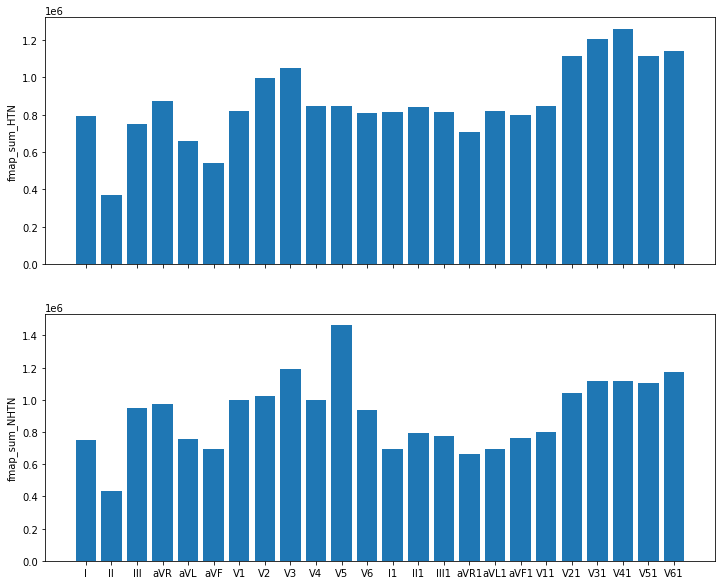

In [13]:
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(nrows = 2,ncols = 1,figsize=(12,10) ,sharex=True)  # type: ignore

leads = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6','I1', 'II1', 'III1', 'aVR1', 'aVL1', 'aVF1', 'V11', 'V21', 'V31', 'V41', 'V51', 'V61',]
counts = branch_fmap_sum_HTN[:24].tolist()
ax0.bar(leads, counts)
ax0.set_ylabel('fmap_sum_HTN')

counts = branch_fmap_sum_NHTN[:24].tolist()
ax1.bar(leads, counts)
ax1.set_ylabel('fmap_sum_NHTN')
plt.show()

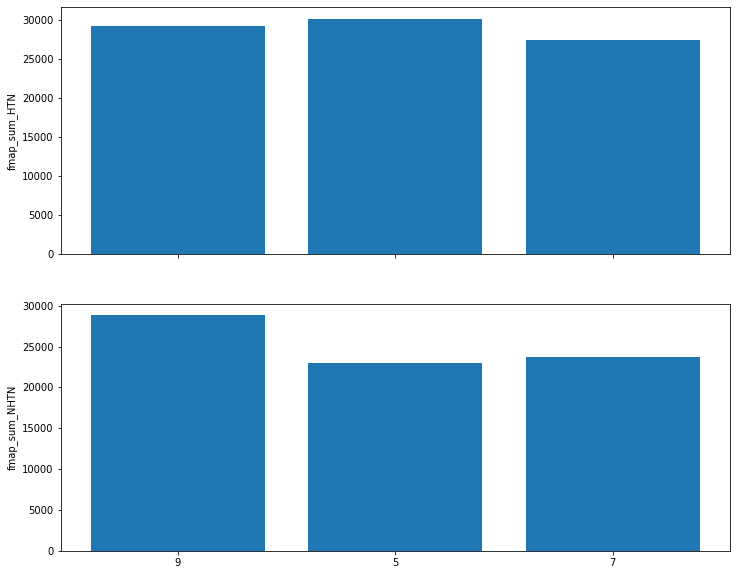

In [15]:
fig, (ax0, ax1) = plt.subplots(nrows = 2,ncols = 1,figsize=(12,10) ,sharex=True)  # type: ignore

leads = ['9', '5', '7']
counts = branch_fmap_sum_HTN[24:].tolist()
ax0.bar(leads, counts)
ax0.set_ylabel('fmap_sum_HTN')

counts = branch_fmap_sum_NHTN[24:].tolist()
ax1.bar(leads, counts)
ax1.set_ylabel('fmap_sum_NHTN')
plt.show()

In [ ]:
fmap = (fmap_block[0][0]).to('cpu').detach().numpy()
gradmap = (grad_block[0][0]).to('cpu').detach().numpy()

In [ ]:
fmap.shape

In [ ]:
gradmap.shape

In [ ]:

grad_cam_pp_vlue = cam.caculate_grad_cam_pp_vlue(fmap,gradmap)
grad_cam_vlue = cam.caculate_grad_cam_vlue(fmap,gradmap)
layer_cam_vlue = cam.caculate_layer_cam_vlue(fmap,gradmap)


In [ ]:
fc_weight_0 = (testmodel.fc.weight[1,0:384].detach().numpy())
fc_weight_0 = np.expand_dims(fc_weight_0,axis=1)
cam_value = cam.caculate_cam_vlue(fmap,fc_weight_0)

In [ ]:
x = np.arange(0,5000)
#y = cam_value
y1 = grad_cam_vlue
y2 = grad_cam_pp_vlue
y3 = layer_cam_vlue
fig, ax = plt.subplots(figsize=(16,9))

#l1, = ax.plot(x,y,label='CAM')
l2, =ax.plot(x,y1,label='Grad CAM')
l3, =ax.plot(x,y2,label='Grad CAM++')
l4, =ax.plot(x,y3,label='Layer')

plt.legend([l2,l3,l4],['Grad CAM','Grad CAM++','Layer'])


In [ ]:
x_index = np.arange(0,EcgLength_num)
fig, axs = plt.subplots(nrows=6, ncols=2, sharex=True,sharey=True,figsize=(50,60), constrained_layout=True)
ecg_data = (inputs[0]).to('cpu')
for i,ax in enumerate(axs.flat):  # type: ignore
    attention_value_each_timestep = layer_cam_vlue
    #plot_y = x[1,i,:]*(4.88)
    
    plot_y = np.array(ecg_data[i]*3500.)
    ECGplot.plot_multicolored_line(fig,ax,x = x_index,y= plot_y,color_depend=attention_value_each_timestep,cmap="jet",y_name = str(lead_index[i])+" Voltage(mV)",title = lead_index[i])
    plot_top_attention_points(fig,ax,x = x_index,y= plot_y,color_depend=attention_value_each_timestep,cmap="jet",y_name = str(lead_index[i])+" Voltage(mV)",title = lead_index[i],top_num=500)

In [ ]:
testmodel.eval()
# 定义获取梯度的函数
fmap_block = list()
grad_block = list()

def backward_hook(module, grad_in, grad_out):
    grad_block.append(grad_out[0].detach())

# 定义获取特征图的函数
def farward_hook(module, input, output):
    fmap_block.append(output)


# 存放梯度和特征图
# testmodel.layers2_list[0].register_forward_hook(farward_hook)	#正向传播
# testmodel.layers2_list[0].register_full_backward_hook(backward_hook)#反向传播
testmodel.layer4.register_forward_hook(farward_hook)	#正向传播
testmodel.layer4.register_full_backward_hook(backward_hook)#反向传播


itme = 12
inputs,labels = test_Dataset.__getitem__(itme)

labels = labels.unsqueeze(0) # 在首位添加1维作为batchsize
inputs = inputs.unsqueeze(0) # 在首位添加1维作为batchsize

inputs = inputs.to(DEVICE)
labels = labels.to(DEVICE)  

outputs = testmodel(inputs)
_,pred = outputs.max(1)     # 求概率最大值对应的标签
print("labels: {}".format(labels))
print("predict: {}".format(pred))
loss = outputs[0,pred]      # 网络对应于pred的类别的输出即为loss
# loss = (testmodel.last_out)[0,pred]
loss.backward(retain_graph=True)  #retain_graph=True，目的为是为保留该过程中计算的梯度，后续G网络更新时使用

In [ ]:
fmap = (fmap_block[0][0]).to('cpu').detach().numpy()
gradmap = (grad_block[0][0]).to('cpu').detach().numpy()


In [ ]:
layer2d_vlue = cam.caculate_layer_cam_vlue_2d(fmap,gradmap)

In [ ]:
layer2d_vlue.shape

In [ ]:
def plot_top_attention_points(fig,axs,x,y,color_depend,cmap = "jet",y_name = "Voltage(mV)",title="",top_num = 100):
    ax.plot(x,y, color='black',linewidth=0.5)
    
    top_idx=color_depend.argsort()[::-1][0:top_num]
    ax.scatter(top_idx, y[top_idx],s=2,c='r')
    #fig.colorbar(line, ax=axs)
    axs.set_xlim(x.min(), x.max())
    axs.set_ylim(-3500, +3500)

    axs.set_aspect(0.2)#用于设置轴缩放的方面，即y-unit与x-unit的比率
    axs.xaxis.set_major_locator(plt.MultipleLocator(100))# type: ignore # 100*0.002s=0.2s = 5格
    axs.xaxis.set_minor_locator(plt.MultipleLocator(20)) # type: ignore # 20*0.002=0.004S = 1格
    axs.yaxis.set_major_locator(plt.MultipleLocator(500))# type: ignore # 0.1uv*500 = 0.5ms = 5格
    axs.yaxis.set_minor_locator(plt.MultipleLocator(100))# type: ignore # 0.1uv*100 =0.1ms = 1格 

    #axs.xaxis.set_major_formatter(plt.NullFormatter()) #x轴不显示刻度值/lable per 0.2s
    axs.xaxis.set_major_formatter(lambda x, pos: str(round(0.2*(x/100.0),2))) #x轴 lable per 0.2s
    axs.yaxis.set_major_formatter(lambda x, pos: str(x/1000.0)) # label per '0.5 mv'，turn uV to mv

    axs.grid(which='major', axis='x', linewidth=0.3, linestyle='-', color='b')
    axs.grid(which='minor', axis='x', linewidth=0.1, linestyle='-', color='b')
    axs.grid(which='major', axis='y', linewidth=0.3, linestyle='-', color='b')
    axs.grid(which='minor', axis='y', linewidth=0.1, linestyle='-', color='b')
    axs.set_ylabel(y_name)
    axs.set_title(title)
    axs.grid(True, which='both')

In [ ]:
channel_cam = layer2d_vlue.sum(axis=1)
timestep_cam = layer2d_vlue.sum(axis=0)

In [ ]:
fig, ax = plt.subplots()
ax.bar(lead_index, channel_cam)
plt.show()

In [ ]:
x_index = np.arange(0,EcgLength_num)
fig, axs = plt.subplots(nrows=6, ncols=2, sharex=True,sharey=True,figsize=(50,60), constrained_layout=True)
ecg_data = (inputs[0]).to('cpu')
for i,ax in enumerate(axs.flat):  # type: ignore
    attention_value_each_timestep = layer2d_vlue[i]
    #plot_y = x[1,i,:]*(4.88)
    
    plot_y = np.array(ecg_data[i]*3500.)
    ECGplot.plot_multicolored_line(fig,ax,x = x_index,y= plot_y,color_depend=attention_value_each_timestep,cmap="jet",y_name = str(lead_index[i])+" Voltage(mV)",title = lead_index[i])
    plot_top_attention_points(fig,ax,x = x_index,y= plot_y,color_depend=attention_value_each_timestep,cmap="jet",y_name = str(lead_index[i])+" Voltage(mV)",title = lead_index[i],top_num=500)